In [1]:
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from dowhy import CausalModel, gcm # type: ignore

from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.neighbors import NearestNeighbors # type: ignore

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

/Users/annanatasha/Documents/DSO 585 Consulting/causal-attribution-analysis/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/processed/data.csv")
df.shape

In [4]:
# Temporary fix for imputing rating
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

## Potential Outcomes: Effect of Delayed Deliveries on Revenue

**Finding the optimal lag**

Lags are crucial in time-series and temporal data analysis because they allow us to account for delayed effects. In this case, a delay in delivery and previous ratings might not immediately impact the payment value but could affect future transactions (e.g., customer dissatisfaction resulting in lower payment values for future purchases). By introducing lags, we can model the relationship between the variables delivery delay (is_delivery_late) and payment value (payment_value) to see how past events influence future outcomes.

The code below is broken down into several steps:
1. Create lagged variables 
2. Evaluate lagged features using cross-validation: evaluates different lag lengths using cross-validation to see which lag performs the best in predicting payment value
3. Modelling with Random Forest Regressor: 
4. Training and Testing: the random forest regressor is trained on the training data, and predictions are made for both the training and test sets. 
5. Evaluate different lags: calculates the MSE for each lag.

We evaluate different lags from 1 to 7 days and calculate the MSE for each lag. The best lag is the one with the lowest MSE, and would tell us the optimal number of days to lag the variables for the most accurate predictions.

In [4]:
#Imports
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [5]:
# Function to create lagged variables of 'is_delivery_late' and 'Rating', grouped by 'customer_id'
def create_specific_lag(df, group_by, lag_features, lag_day):
    for feature in lag_features:
        # Shift the feature values within each group by the specific lag day only
        df[f'{feature}_lag{lag_day}'] = df.groupby(group_by)[feature].shift(lag_day)
    return df

# Function to evaluate different specific lags using cross-validation and Train-Test Split
def evaluate_specific_lags(df, group_by, lag_range, lag_features, outcome_var):
    results = []  # This will store the (lag_day, mse_score) pairs
    
    for lag_day in lag_range:
        # Create only the specific lag_day variables
        df_lagged = df.copy()
        df_lagged = create_specific_lag(df_lagged, group_by, lag_features, lag_day)

        # Drop missing values (due to lag creation)
        df_lagged = df_lagged.dropna(subset=[f'{feature}_lag{lag_day}' for feature in lag_features] + [outcome_var])

        # Prepare features (X) and target (y)
        X = df_lagged.drop(columns=[outcome_var])  # Independent variables
        y = df_lagged[outcome_var]  # Dependent variable (outcome)

        # Ensure features are numeric
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize a Random Forest Regressor model
        model = RandomForestRegressor(random_state=42, n_estimators=100)

        # Fit the model
        model.fit(X_train, y_train)

        # Calculate training and testing Mean Squared Error (MSE)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        # Check for potential overfitting
        if train_mse > test_mse:
            print(f"Warning: Possible overfitting for lag {lag_day}. Train MSE is higher than Test MSE.")

        # Store the result as a tuple (lag_day, test_mse)
        results.append((lag_day, test_mse))

    return results

# Define features and target
lag_features = ['is_delivery_late', 'Rating']  # Features you want to lag
outcome_var = 'payment_value'  # Target variable

# Define the group to lag within (e.g., by 'customer_id')
group_by = 'customer_id'

# Define the range of specific lags to evaluate
lag_range = range(1, 8)  # Test from 1 day to 7 days

# Call the function and evaluate specific lag days
results = evaluate_specific_lags(df, group_by, lag_range, lag_features, outcome_var)

# Print results for different lag days
for lag_day, score in results:
    print(f"Lag {lag_day}: Avg Mean Squared Error (MSE) = {score}")

# Choose the best lag based on the score (lower MSE is better)
optimal_lag = min(results, key=lambda x: x[1])[0]
print(f"Optimal number of days for lag: {optimal_lag}")

Lag 1: Avg Mean Squared Error (MSE) = 16909.457452648472
Lag 2: Avg Mean Squared Error (MSE) = 48487.05168153216
Lag 3: Avg Mean Squared Error (MSE) = 109602.04743424559
Lag 4: Avg Mean Squared Error (MSE) = 61600.17186393931
Lag 5: Avg Mean Squared Error (MSE) = 124029.83992587507
Lag 6: Avg Mean Squared Error (MSE) = 19815.689351634384
Lag 7: Avg Mean Squared Error (MSE) = 39750.92050041857
Optimal number of days for lag: 1


**One Day Lag Incorporated**

In [7]:
df['is_delivery_late_lag1'] = df.groupby('customer_id')['is_delivery_late'].shift(1)

In [8]:
# Define covariates, treatment, and outcome
covariates = ['Product_category', 'season', 'Product_size', 'freight_value', 'distance_km']
treatment = 'is_delivery_late_lag1'  # Define treatment as the 1-day lag version
outcome = 'payment_value'

In [9]:
# Check the unique values of the treatment variable
print(df['is_delivery_late_lag1'].value_counts())

is_delivery_late_lag1
0.0    18282
1.0     1021
Name: count, dtype: int64


In [10]:
# Drop rows with missing values due to lagging
df = df.dropna(subset=[treatment, outcome])  # Ensure no NaNs after lag creation

In [11]:
# Build the causal model using the lagged treatment
model = CausalModel(
    data=df,
    treatment=treatment,  # Use lagged treatment
    outcome=outcome,
    common_causes=covariates
)

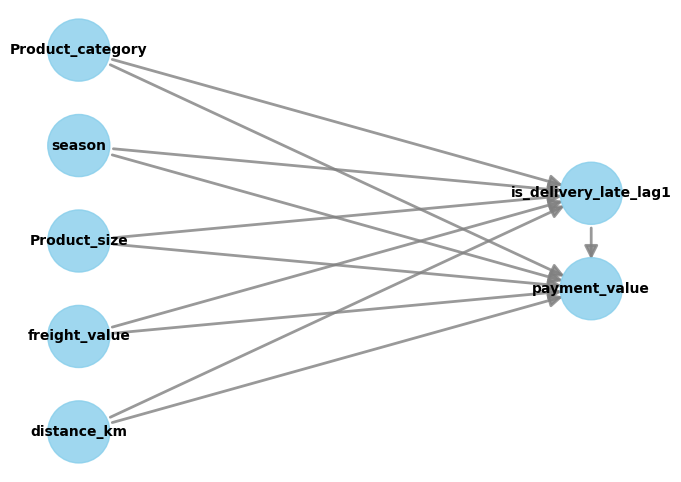

In [12]:
# View the graphical model (optional)
model.view_model()

In [13]:
# Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                   ↪
────────────────────────(E[payment_value|freight_value,Product_size,season,Pro ↪
d[is_delivery_late_lag1]                                                       ↪

↪                            
↪ duct_category,distance_km])
↪                            
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late_lag1} and U→payment_value then P(payment_value|is_delivery_late_lag1,freight_value,Product_size,season,Product_category,distance_km,U) = P(payment_value|is_delivery_late_lag1,freight_value,Product_size,season,Product_category,distance_km)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [14]:
# Estimate the treatment effect using propensity score matching
# This will estimate the causal effect using Propensity Score Matching (PSM).
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

In [15]:
# This will show the average treatment effect (ATE) of late deliveries on payment value.
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                   ↪
────────────────────────(E[payment_value|freight_value,Product_size,season,Pro ↪
d[is_delivery_late_lag1]                                                       ↪

↪                            
↪ duct_category,distance_km])
↪                            
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late_lag1} and U→payment_value then P(payment_value|is_delivery_late_lag1,freight_value,Product_size,season,Product_category,distance_km,U) = P(payment_value|is_delivery_late_lag1,freight_value,Product_size,season,Product_category,distance_km)

## Realized estimand
b: payment_value~is_delivery_late_lag1+freight_value+Product_size+season+Product_category+distance_km
Target units: ate

## Estimate
Mean value: -46.500456453033955



Bootstrap Confidence Interval

In [16]:
# Display the causal estimate, confidence intervals, and standard error
print("Causal Estimate (ATE):", estimate.value)

Causal Estimate (ATE): -46.500456453033955


In [17]:
print("Confidence Interval:", estimate.get_confidence_intervals())

Confidence Interval: (np.float64(-68.87433656287335), np.float64(-38.53977980415542))


In [18]:
print("Standard Error:", estimate.get_standard_error())

Standard Error: 8.023908457494127


Sensitivity Analysis: Unobserved Confounder

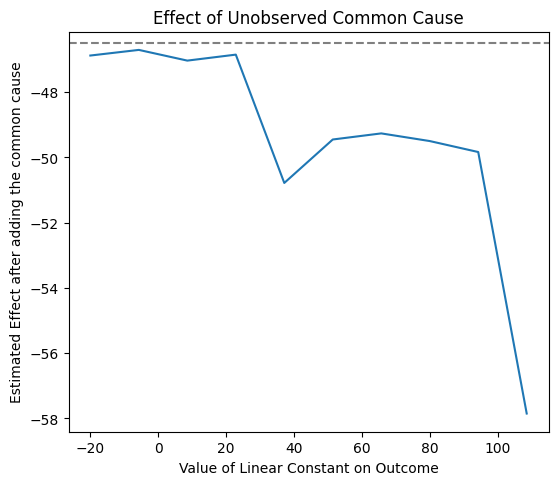

In [19]:
# Add an unobserved confounder and see how the treatment effect changes
refutation_unobserved_confounding = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause"
)

In [20]:
# Display the refutation results
print(refutation_unobserved_confounding)

Refute: Add an Unobserved Common Cause
Estimated effect:-46.500456453033955
New effect:(np.float64(-57.850102644705686), np.float64(-46.704198178203214))



ATT (Average Treatment Effect on Treated)

In [21]:
# Estimate ATT using DoWhy
estimate_ATT = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att"  # Specify that we are interested in the ATT (treated units)
)

In [22]:
# Display the ATT
print("ATT (Average Treatment effect on the Treated):", estimate_ATT.value)

ATT (Average Treatment effect on the Treated): -8.927428851815513


ATC (Average Treatment Effect on Control)

In [23]:
# Estimate ATC using DoWhy
estimate_ATC = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="atc"  # Specify that we are interested in the ATC (control units)
    #ATC is where is_delivery_late = 0, so what would the outcome have been for those who didn't experience a delayed delivery, if they had
)

In [24]:
# Display the ATC
print("ATC (Average Treatment effect on the Controls):", estimate_ATC.value)

ATC (Average Treatment effect on the Controls): -48.59469751668353


-----